In [93]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from ast import literal_eval
import string

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
stop_words = nltk.corpus.stopwords.words('english')
stop_words += ['mr', 'mrs', 'come', 'go', 'get', 'tell',
'listen', 'one', 'two', 'three', 'four', 'five',
'six', 'seven', 'eight',
'nine', 'zero', 'join', 'find', 'make', 'say', 'ask',
'tell', 'see', 'try', 'back', 'also']

For this assignment, I divided my text into "republican party" data and "democratic party" data, and "democratic party" data will be used to answer questions.

### 1. Using your corpus and the gensim package, create an LDA Topic Model.

### 1a. Provide the raw Keywords and loadings for at least 5 Topics (10+ preferred).

In [4]:
df = pd.read_csv("../Project/df.csv")
df = df.drop(["Unnamed: 0"],axis = 1)
df.head()

,Speaker,FileName,RawText,Token,Cleaned_text,Sent_Token,Normalized_list
0,BUSH,../Project/Data/BUSH/BUSH-0.txt,thank you very much. i want to thank arizona ...,"['thank', 'much', 'want', 'thank', 'arizona', ...",thank much want thank arizona state well yes s...,"[' thank you very much.', 'i want to thank ari...","[['thank', 'much'], ['want', 'thank', 'arizona..."
1,BUSH,../Project/Data/BUSH/BUSH-1.txt,"gosh, i just do not think i ever said i am no...","['gosh', 'think', 'ever', 'said', 'worried', '...",gosh think ever said worried osama bin laden k...,"[' gosh, i just do not think i ever said i am ...","[['gosh', 'think', 'ever', 'worry', 'osama', '..."
2,BUSH,../Project/Data/BUSH/BUSH-10.txt,i think it is important to promote a culture ...,"['think', 'important', 'promote', 'culture', '...",think important promote culture life think hos...,[' i think it is important to promote a cultur...,"[['think', 'important', 'promote', 'culture', ..."
3,BUSH,../Project/Data/BUSH/BUSH-11.txt,"gosh, i sure hope it is not the administratio...","['gosh', 'sure', 'hope', 'administration', 'lo...",gosh sure hope administration look systemic pr...,"[' gosh, i sure hope it is not the administrat...","[['gosh', 'sure', 'hope', 'administration'], [..."
4,BUSH,../Project/Data/BUSH/BUSH-12.txt,"i think it is important, since he talked abou...","['think', 'important', 'since', 'talked', 'med...",think important since talked medicare plan uni...,"[' i think it is important, since he talked ab...","[['think', 'important', 'since', 'talk', 'medi..."


In [5]:
# show speaker's name
df["Speaker"].unique()

array(['BUSH', 'CRUZ', 'HILLARY', 'KERRY', 'MCCAIN', 'OBAMA', 'ROMNEY',
       'SANDERS', 'TRUMP'], dtype=object)

In [9]:
# Group speakers' into two parties
Dem = ["HILLARY","OBAMA","SANDERS","KERRY"]
Dem_df = df.loc[df['Speaker'].isin(Dem)][['Speaker','Normalized_list']]

def remove_punctuation(l):
    r = []
    not_wanted = ["‘","’",'”','“','–']
    for i in l:
        removed = [x for x in i if x not in not_wanted]
        r.append(removed)
    return r

Dem_df.Normalized_list = Dem_df.Normalized_list.apply(literal_eval)
Dem_sent = Dem_df.Normalized_list.sum()
Dem_sent = remove_punctuation(Dem_sent)

In [17]:
# Create Dictionary
Dem_id2word = corpora.Dictionary(Dem_sent)

# Create Corpus: Term Document Frequency
Dem_corpus = [Dem_id2word.doc2bow(text) for text in Dem_sent]

In [16]:
%%time
Dem_lda_model = gensim.models.ldamodel.LdaModel(corpus=Dem_corpus,
                                           id2word=Dem_id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           iterations=100,
                                           per_word_topics=True)

Wall time: 10.4 s


In [24]:
# Print the Keyword in the 10 topics for Democratic party
pprint(Dem_lda_model.print_topics())
Dem_doc_lda = Dem_lda_model[Dem_corpus]

[(0,
  '0.128*"country" + 0.107*"people" + 0.033*"president" + 0.027*"american" + '
  '0.021*"every" + 0.019*"campaign" + 0.019*"issue" + 0.019*"fact" + '
  '0.017*"system" + 0.017*"view"'),
 (1,
  '0.076*"young" + 0.062*"want" + 0.060*"clinton" + 0.056*"let" + 0.047*"yes" '
  '+ 0.041*"world" + 0.034*"class" + 0.028*"look" + 0.027*"happen" + '
  '0.026*"middle"'),
 (2,
  '0.116*"think" + 0.055*"need" + 0.055*"talk" + 0.045*"debt" + '
  '0.041*"secretary" + 0.034*"history" + 0.030*"give" + 0.028*"house" + '
  '0.023*"billion" + 0.022*"proposal"'),
 (3,
  '0.113*"college" + 0.083*"war" + 0.070*"right" + 0.063*"street" + '
  '0.060*"wall" + 0.052*"believe" + 0.043*"free" + 0.031*"senate" + '
  '0.027*"away" + 0.019*"tuition"'),
 (4,
  '0.095*"vote" + 0.073*"know" + 0.055*"bill" + 0.035*"election" + '
  '0.034*"real" + 0.032*"problem" + 0.024*"around" + 0.022*"number" + '
  '0.020*"big" + 0.019*"address"'),
 (5,
  '0.073*"today" + 0.070*"state" + 0.065*"would" + 0.044*"year" + '
  '0.040*

### 1b. Provide the Perplexity and Coherence scores for your model.

In [37]:
def make_bigrams(texts, mod):
    return [mod[doc] for doc in texts]

def make_trigrams(texts,mod1,mod2):
    return [mod2[mod1[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [81]:
# Build the bigram and trigram models
Dem_bigram = gensim.models.Phrases(Dem_sent, min_count=5, threshold=100) # higher threshold fewer phrases.
Dem_trigram = gensim.models.Phrases(Dem_bigram[Dem_sent], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
Dem_bigram_mod = gensim.models.phrases.Phraser(Dem_bigram)
Dem_trigram_mod = gensim.models.phrases.Phraser(Dem_trigram)


Dem_data_words_bigrams = make_bigrams(Dem_sent,Dem_bigram_mod)
# Do lemmatization keeping only noun, adj, vb, adv
Dem_data_lemmatized = lemmatization(Dem_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [76]:
# Democratic Party

print("For Democratic Party:")
# Compute Perplexity
print('\nPerplexity: ', Dem_lda_model.log_perplexity(Dem_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
dtype=np.float64
Dem_coherence_model_lda = CoherenceModel(model=Dem_lda_model, texts=Dem_data_lemmatized, dictionary=Dem_id2word, coherence='c_v')
Dem_coherence_lda = Dem_coherence_model_lda.get_coherence()
print('\nCoherence Score for Demublican party : ', Dem_coherence_lda)
print('\n')

For Democratic Party:

Perplexity:  -9.45257272295989


C:\Users\hengj\Anaconda_3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\hengj\Anaconda_3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))



Coherence Score for Demublican party :  nan




I added a if condition to the two py files mentioned in the errors to avoid "denominator=0". But I don't know why it still gives me the errors. So I change coherence to u_mass 

In [ ]:
# first error- add if condition
denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
if denominator == 0 or numerator / denominator ==0:
    m_lr_i = 0
else:
    m_lr_i = np.log(numerator / denominator)
    
#second error- add if condition
def _cossim(cv1, cv2):
    if _magnitude(cv1) * _magnitude(cv2) == 0:
        return 0
    else:
        return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


I changed 'coherence' to u_mass it finally gives me a score.

In [77]:
Dem_coherence_model_lda = CoherenceModel(model=Dem_lda_model, texts=Dem_data_lemmatized, dictionary=Dem_id2word, coherence='u_mass')
Dem_coherence_lda = Dem_coherence_model_lda.get_coherence()
print('\nCoherence Score for Demublican party : ', Dem_coherence_lda)
print('\n')


Coherence Score for Demublican party :  -15.193596126949988




### 1c. Provide a screenshot of two Topics from the pyLDAvis.gensim visualization.

For Democratic Party

In [63]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(Dem_lda_model, Dem_corpus, dictionary=Dem_lda_model.id2word)

In [64]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      20.001701        1       1 -0.370033  0.077844
8      12.789234        1       2 -0.041505 -0.353711
7      10.888422        1       3  0.039607  0.043856
2      10.660030        1       4  0.060647  0.037071
5       9.626607        1       5  0.048461  0.013388
1       9.508572        1       6  0.059754  0.076034
9       7.930466        1       7  0.050801  0.052700
6       7.807734        1       8  0.031169  0.027374
3       6.245311        1       9  0.070460  0.006460
4       4.541927        1      10  0.050639  0.018986, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
187   Default  335.000000      country  335.000000  30.0000  30.0000
19    Default  282.000000       people  282.000000  29.0000  29.0000
10    Default  162.000000        think  162.000000  28.0000  28.0000
594   Default   93.000000      college   93.000000  27.0000  27.0000
182   Default   94.000000       family   94.000000  26.0000  26.0000
491   Default   95.000000        young   95.000000  25.0000  25.0000
149   Default   93.000000        today   93.000000  24.0000  24.0000
1362  Default   84.000000      veteran   84.000000  23.0000  23.0000
224   Default   83.000000         many   83.000000  22.0000  22.0000
109   Default   82.000000         care   82.000000  21.0000  21.0000
50    Default   89.000000        state   89.000000  20.0000  20.0000
26    Default  100.000000         well  100.000000  19.0000  19.0000
1181  Default   69.000000          war   69.000000  18.0000  18.0000
51    Default   82.000000        would   82.000000  17.0000  17.0000
69    Default   78.000000         want   78.000000  16.0000  16.0000
39    Default   70.000000           us   70.000000  15.0000  15.0000
306   Default   57.000000         vote   57.000000  14.0000  14.0000
357   Default   76.000000      clinton   76.000000  13.0000  13.0000
8     Default   78.000000         need   78.000000  12.0000  12.0000
9     Default   77.000000         talk   77.000000  11.0000  11.0000
380   Default   77.000000       change   77.000000  10.0000  10.0000
255   Default   70.000000          let   70.000000   9.0000   9.0000
200   Default   57.000000        right   57.000000   8.0000   8.0000
112   Default   61.000000       health   61.000000   7.0000   7.0000
1     Default   71.000000         take   71.000000   6.0000   6.0000
36    Default   59.000000          new   59.000000   5.0000   5.0000
516   Default   52.000000       street   52.000000   4.0000   4.0000
400   Default   65.000000          tax   65.000000   3.0000   3.0000
438   Default   63.000000         debt   63.000000   2.0000   2.0000
517   Default   52.000000         wall   52.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
669   Topic10   14.176953       around   14.975283   3.0370  -3.7385
982   Topic10   13.355491       number   14.153620   3.0338  -3.7981
534   Topic10   12.177820          big   12.976128   3.0283  -3.8905
336   Topic10   11.608863      address   12.407750   3.0253  -3.9383
5     Topic10   10.107301        stand   10.905878   3.0158  -4.0768
194   Topic10    7.819767         face    8.617828   2.9946  -4.3334
970   Topic10    7.388166      assault    8.188479   2.9890  -4.3902
1106  Topic10    5.700919       member    6.499162   2.9608  -4.6494
1809  Topic10    6.085081   throughout    6.947353   2.9593  -4.5842
834   Topic10    5.333210      mistake    6.145910   2.9500  -4.7161
612   Topic10    4.816991        solve    5.615100   2.9385  -4.8179
225   Topic10    3.898506         turn    4.696979   2.9055  -5.0295
394   Topic10    3.178151      company    3.978865   2.8671  -5.2338
787   Topic10    2.377295         move    3.175292   2.8024  -5.5241
1615  Topic10    2.352518       weapon    3.159878   2.7968  -5.53

In [65]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      20.001701        1       1 -0.370033  0.077844
8      12.789234        1       2 -0.041505 -0.353711
7      10.888422        1       3  0.039607  0.043856
2      10.660030        1       4  0.060647  0.037071
5       9.626607        1       5  0.048461  0.013388
1       9.508572        1       6  0.059754  0.076034
9       7.930466        1       7  0.050801  0.052700
6       7.807734        1       8  0.031169  0.027374
3       6.245311        1       9  0.070460  0.006460
4       4.541927        1      10  0.050639  0.018986, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
187   Default  335.000000      country  335.000000  30.0000  30.0000
19    Default  282.000000       people  282.000000  29.0000  29.0000
10    Default  162.000000        think  162.000000  28.0000  28.0000
594   Default   93.000000      college   93.000000  27.0000  27.0000
182   Default   94.000000       family   94.000000  26.0000  26.0000
491   Default   95.000000        young   95.000000  25.0000  25.0000
149   Default   93.000000        today   93.000000  24.0000  24.0000
1362  Default   84.000000      veteran   84.000000  23.0000  23.0000
224   Default   83.000000         many   83.000000  22.0000  22.0000
109   Default   82.000000         care   82.000000  21.0000  21.0000
50    Default   89.000000        state   89.000000  20.0000  20.0000
26    Default  100.000000         well  100.000000  19.0000  19.0000
1181  Default   69.000000          war   69.000000  18.0000  18.0000
51    Default   82.000000        would   82.000000  17.0000  17.0000
69    Default   78.000000         want   78.000000  16.0000  16.0000
39    Default   70.000000           us   70.000000  15.0000  15.0000
306   Default   57.000000         vote   57.000000  14.0000  14.0000
357   Default   76.000000      clinton   76.000000  13.0000  13.0000
8     Default   78.000000         need   78.000000  12.0000  12.0000
9     Default   77.000000         talk   77.000000  11.0000  11.0000
380   Default   77.000000       change   77.000000  10.0000  10.0000
255   Default   70.000000          let   70.000000   9.0000   9.0000
200   Default   57.000000        right   57.000000   8.0000   8.0000
112   Default   61.000000       health   61.000000   7.0000   7.0000
1     Default   71.000000         take   71.000000   6.0000   6.0000
36    Default   59.000000          new   59.000000   5.0000   5.0000
516   Default   52.000000       street   52.000000   4.0000   4.0000
400   Default   65.000000          tax   65.000000   3.0000   3.0000
438   Default   63.000000         debt   63.000000   2.0000   2.0000
517   Default   52.000000         wall   52.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
669   Topic10   14.176953       around   14.975283   3.0370  -3.7385
982   Topic10   13.355491       number   14.153620   3.0338  -3.7981
534   Topic10   12.177820          big   12.976128   3.0283  -3.8905
336   Topic10   11.608863      address   12.407750   3.0253  -3.9383
5     Topic10   10.107301        stand   10.905878   3.0158  -4.0768
194   Topic10    7.819767         face    8.617828   2.9946  -4.3334
970   Topic10    7.388166      assault    8.188479   2.9890  -4.3902
1106  Topic10    5.700919       member    6.499162   2.9608  -4.6494
1809  Topic10    6.085081   throughout    6.947353   2.9593  -4.5842
834   Topic10    5.333210      mistake    6.145910   2.9500  -4.7161
612   Topic10    4.816991        solve    5.615100   2.9385  -4.8179
225   Topic10    3.898506         turn    4.696979   2.9055  -5.0295
394   Topic10    3.178151      company    3.978865   2.8671  -5.2338
787   Topic10    2.377295         move    3.175292   2.8024  -5.5241
1615  Topic10    2.352518       weapon    3.159878   2.7968  -5.53

### 1d. In 2-3 sentences, comment on the Topics you have provided and whether you feel they accurately represent topics in your corpus.

I think most topics are reasonable and very accurate. As I select transcripts of speeches in presidential elections. Most words in topics are relevant to politics, asking for votes, donations and campaign.

### 2. Using your LDA Topic Model, provide the following:

### 2a. The raw Keywords and loadings for at least 4 Topics.

In [85]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=Dem_corpus,
                                           id2word=Dem_id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [86]:
pprint(lda_model.print_topics())

[(0,
  '0.032*"college" + 0.024*"care" + 0.022*"today" + 0.021*"us" + 0.020*"let" + '
  '0.018*"health" + 0.018*"veteran" + 0.018*"new" + 0.016*"support" + '
  '0.016*"vote"'),
 (1,
  '0.082*"country" + 0.027*"well" + 0.026*"family" + 0.024*"many" + '
  '0.021*"want" + 0.016*"change" + 0.016*"economy" + 0.016*"yes" + '
  '0.014*"world" + 0.012*"campaign"'),
 (2,
  '0.042*"think" + 0.022*"clinton" + 0.022*"state" + 0.020*"would" + '
  '0.020*"need" + 0.020*"talk" + 0.016*"public" + 0.016*"take" + 0.016*"va" + '
  '0.014*"work"'),
 (3,
  '0.067*"people" + 0.025*"young" + 0.022*"war" + 0.020*"president" + '
  '0.018*"right" + 0.017*"american" + 0.014*"debt" + 0.014*"believe" + '
  '0.014*"street" + 0.013*"wall"')]


### 2b. A chart of the dominant Topics with the “percentage contribution” for at least the first 10 documents.

In [87]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=Dem_corpus, texts=Dem_data_lemmatized )

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.8125,"think, clinton, state, would, need, talk, publ...","[know, take, thing]"
1,1,2.0,0.4691,"think, clinton, state, would, need, talk, publ...","[know, common, ground, know, stand, ground]"
2,2,2.0,0.7099,"think, clinton, state, would, need, talk, publ...","[think, need, washington, anything, talk, acco..."
3,3,3.0,0.9275,"people, young, war, president, right, american...","[happy, commitment, lifetime, experience, life..."
4,4,1.0,0.5322,"country, well, family, many, want, change, eco...","[actually, consistent, course, entire, life]"
5,5,1.0,0.4806,"country, well, family, many, want, change, eco...","[always, fight, value, principle]"
6,6,0.0,0.5954,"college, care, today, us, let, health, veteran...","[human, include, run, office, absorb, new, inf..."
7,7,1.0,0.8125,"country, well, family, many, want, change, eco...","[look, happen, world]"
8,8,2.0,0.6504,"think, clinton, state, would, need, talk, publ...","[know, take, trade, deal]"
9,9,2.0,0.9157,"think, clinton, state, would, need, talk, publ...","[secretary, state, year, hop, would, gold, sta..."


### 2c. Word clouds for at least 4 Topics.

In [88]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9308,"college, care, today, us, let, health, veteran, new, support, vote","[franklin, roosevelt, care, idea, republican, idea, democrat, idea]"
1,1.0,0.9157,"country, well, family, many, want, change, economy, yes, world, campaign","[push, core, principle, sure, taxpayer, money, put, money]"
2,2.0,0.9400,"think, clinton, state, would, need, talk, public, take, va, work","[year, ago, year, old, engage, despicable, act, radical, domestic, group]"
3,3.0,0.9460,"people, young, war, president, right, american, debt, believe, street, wall","[apparently, pay, people, register, folk, apparently, people, really, register, people, fill, bu..."


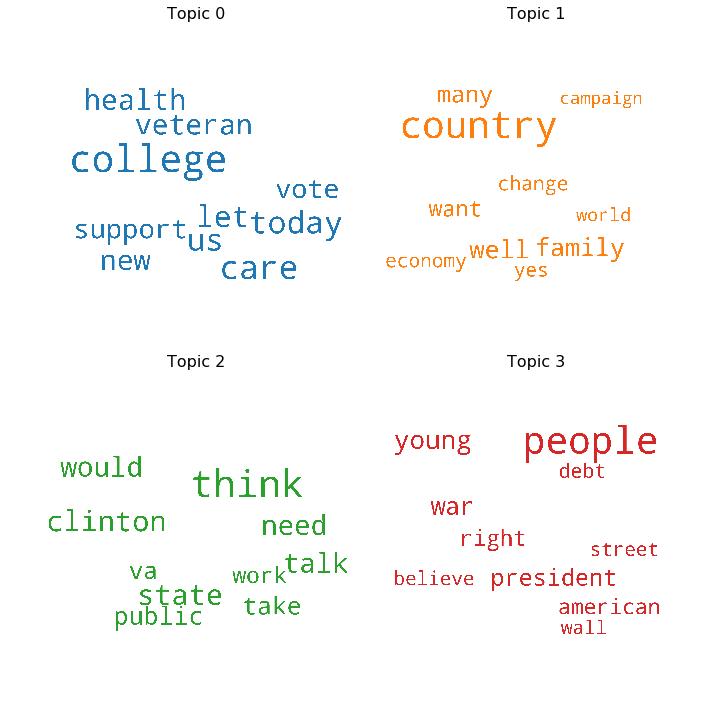

In [94]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 2d. The Word Count and Importance of Topic Keywords for at least 4 topics.

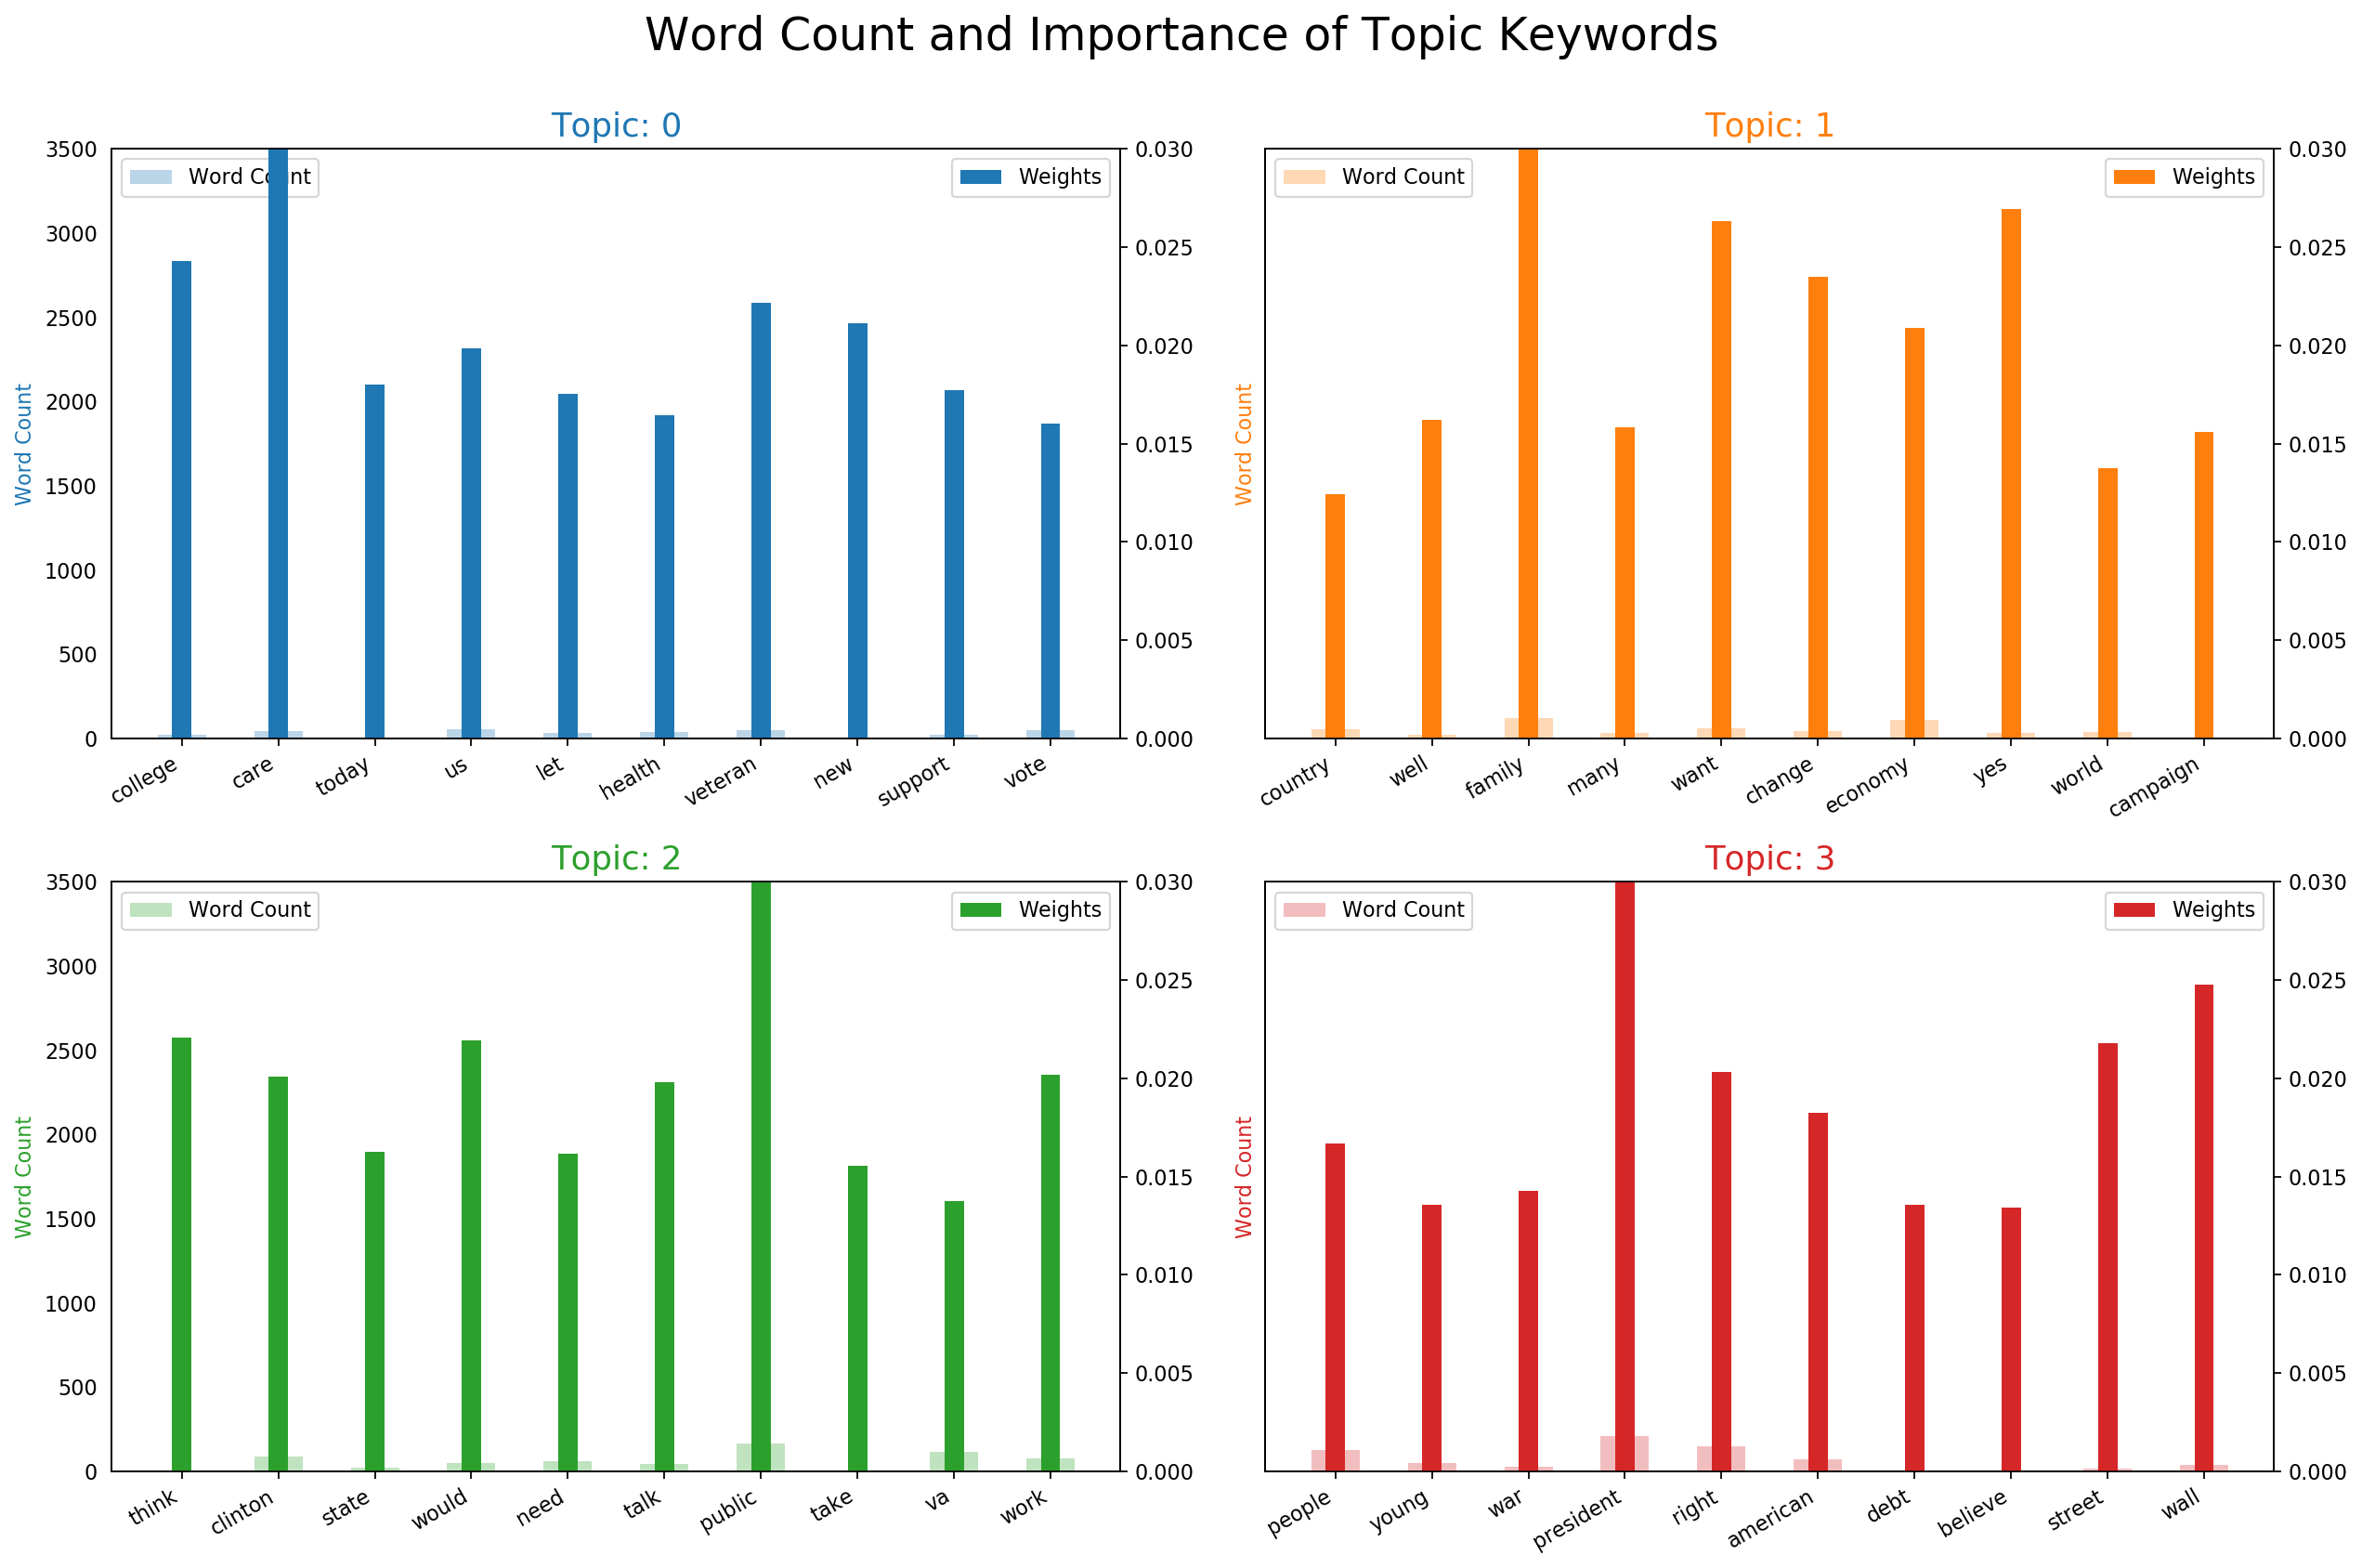

In [96]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in Dem_data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### 2e. A bokeh visualization of the t-SNE Topic Clusters.

In [98]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[Dem_corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1637 samples in 0.002s...
[t-SNE] Computed neighbors for 1637 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1637
[t-SNE] Computed conditional probabilities for sample 1637 / 1637
[t-SNE] Mean sigma: 0.021098
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.137421
[t-SNE] Error after 1000 iterations: 0.544760


Loading BokehJS ...